# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [34]:
# import libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparikfy churn") \
    .config("spark.default.parallelism", 1000) \
    .config("spark.sql.shuffle.partitions", 8) \
    .getOrCreate()

In [3]:
import pyspark
from pyspark import SparkConf
SparkConf().getAll()

[('spark.default.parallelism', '1000'),
 ('spark.master', 'local[*]'),
 ('spark.submit.deployMode', 'client'),
 ('spark.sql.shuffle.partitions', '8'),
 ('spark.app.name', 'Sparikfy churn'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [5]:
user_log.createOrReplaceTempView("data")


In [6]:
#checking for any missing userId's or sessionId's, none
spark.sql('''
        select *
        from data


''').printSchema()

spark.sql('''
        select *
        from data
        where userId is null or sessionId is null
''').show()

#noticed that there were null songs, that is when page's value is not'next song'
spark.sql('''
        select distinct page
        from data
        where song is not null
''').show(40)



root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+----

In [7]:
spark.sql('''
        select *
        from data


''').toPandas().head()


,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [8]:
spark.udf.register("minute", lambda x: str(datetime.datetime.fromtimestamp(x / 1000.0).minute))
spark.udf.register("seconds", lambda x: str(datetime.datetime.fromtimestamp(x / 1000.0).second))
spark.udf.register("date", lambda x: str(datetime.datetime.fromtimestamp(x / 1000.0)))

<function __main__.<lambda>(x)>

In [9]:
spark.sql('''
        select *,minute(ts) as minute,seconds(ts) as seconds, date(ts) as date, date(registration) as registrationdate
        from data
        where userId != ''
        order by userId, sessionId, ts asc
''')

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, minute: string, seconds: string, date: string, registrationdate: string]

In [10]:
#the ratio of time spent listening to songs vs spent in the in between stages
time_data = spark.sql('''
          select *, unix_timestamp(datesntimes) - unix_timestamp(previous_datetime) as timediffinsecs
              From (select *, LAG(datesntimes) OVER (
                PARTITION BY userid, sessionid 
                ORDER BY datesntimes) previous_datetime
                from (
                    select userId, sessionId,page, CAST(date(ts) as timestamp) as datesntimes
                    from data
                    where userId != ''
                    order by userId, sessionId, ts asc))
    
                order by datesntimes
               
''')

time_data.createOrReplaceTempView("time_data")


listening_ratio = spark.sql("""
        
        select userid, ifnull(sum(total_time_non_listening),0) as no_listen_time, ifnull(sum(total_time_per_session),0) as total_time, ifnull(sum(total_time_non_listening/total_time_per_session),0) as listening_ratio
        from(
            select abc.userid, abc.sessionid, abc.total_time_per_session, b.total_time_non_listening
            from
                (select userid, sessionid, sum(timediffinsecs) as total_time_per_session
                from time_data
                group by userid, sessionid
                order by sessionid) abc

                left join (select userid, sessionid, sum(timediffinsecs) as total_time_non_listening
                    from time_data
                    where page != 'NextSong'
                    group by userid, sessionid
                    order by sessionid) as b 
            on abc.userid = b.userid and abc.sessionid = b.sessionid
            order by userid, sessionid asc)
           group by userid
           order by userid
        
""")
listening_ratio.createOrReplaceTempView("listening_vectors")

In [11]:
#turning the data into one user per row so that I can create a vector to use for the models

pivot_data = spark.sql('''
        
        select userId, sessionId, page, count(page) as page_count
        from data
        where userId != ""
        group by userId, sessionId, page
        order by userId, sessionId, page_count desc
        

''')
pivot_data.createOrReplaceTempView("pivot_data")

transformed_data = spark.sql('''
            select userId, sessionId,
                sum(CancellationConfirmation) as CancellationConfirmation,
                sum(SubmitUpgrade) as SubmitUpgrade,
                sum(Upgrade) as Upgrade,
                sum(Help) as Help,
                sum(ThumbsUp) as ThumbsUp,
                sum(NextSong) as NextSong,
                sum(AddFriend) as AddFriend,
                sum(AddtoPlaylist) as AddtoPlaylist,
                sum(Settings) as Settings,
                sum(About) as About,
                sum(SaveSettings) as SaveSettings,
                sum(Logout) as Logout,
                sum(RollAdvert) as RollAdvert,
                sum(Downgrade) as Downgrade,
                sum(Home) as Home,
                sum(ThumbsDown) as ThumbsDown,
                sum(SubmitDowngrade) as SubmitDowngrade,
                sum(Cancel) as Cancel
                
                from (select pivot_data.*,
                    case when page = "Cancellation Confirmation" then page_count else 0 end as CancellationConfirmation,
                    case when page = "Submit Upgrade" then page_count  else 0 end as SubmitUpgrade,
                    case when page = "Upgrade" then page_count  else 0 end as Upgrade,
                    case when page = "Help" then page_count  else 0 end as Help,
                    case when page = "Thumbs Up" then page_count  else 0 end as ThumbsUp,
                    case when page = "NextSong" then page_count  else 0 end as NextSong,
                    case when page = "Add Friend" then page_count  else 0 end as AddFriend,
                    case when page = "Add to Playlist" then page_count  else 0 end as AddtoPlaylist,
                    case when page = "Settings" then page_count  else 0 end as Settings,
                    case when page = "About" then page_count  else 0 end as About,
                    case when page = "Save Settings" then page_count  else 0 end as SaveSettings,
                    case when page = "Logout" then page_count  else 0 end as Logout,
                    case when page = "Roll Advert" then page_count  else 0 end as RollAdvert,
                    case when page = "Downgrade" then page_count  else 0 end as Downgrade,
                    case when page = "Home" then page_count  else 0 end as Home,
                    case when page = "Thumbs Down" then page_count  else 0 end as ThumbsDown,
                    case when page = "Submit Downgrade" then page_count  else 0 end as SubmitDowngrade,
                    case when page = "Cancel" then page_count  else 0 end as Cancel
                from pivot_data) pivot_ext
                group by userId, sessionId
                order by userId, sessionId asc
''')
transformed_data.createOrReplaceTempView("transformed_vectors")



transform_vector = spark.sql('''
        select userId, sum(CancellationConfirmation) as CancellationConfirmation,
                sum(SubmitUpgrade) as SubmitUpgrade,
                sum(Upgrade) as Upgrade,
                sum(Help) as Help,
                sum(ThumbsUp) as ThumbsUp,
                sum(NextSong) as NextSong,
                sum(AddFriend) as AddFriend,
                sum(AddtoPlaylist) as AddtoPlaylist,
                sum(Settings) as Settings,
                sum(About) as About,
                sum(SaveSettings) as SaveSettings,
                sum(Logout) as Logout,
                sum(RollAdvert) as RollAdvert,
                sum(Downgrade) as Downgrade,
                sum(Home) as Home,
                sum(ThumbsDown) as ThumbsDown,
                sum(SubmitDowngrade) as SubmitDowngrade,
                sum(Cancel) as Cancel
        from transformed_vectors
        group by userId
''')
transform_vector.createOrReplaceTempView("transform_vector")

In [12]:

#number of sessions each user has completed
num_sessions_vector = spark.sql('''
        
        select userId, count(*) as sessions
        FROM (select distinct userId, sessionId
                from data
                where userId != "")
        group by userId
        order by sessions Desc
        

''')

num_sessions_vector.createOrReplaceTempView('num_vectors')

In [13]:
#bring all the different engineered features into one table

feature_engineered = spark.sql('''
                select trans.*, listen.no_listen_time, listen.total_time, listen.listening_ratio, num_sess.sessions 
                    from listening_vectors listen
                left join num_vectors num_sess
                on listen.userid = num_sess.userid
                left join transform_vector trans
                on trans.userid = listen.userid
                where listen.no_listen_time is not null or listen.total_time is not null                
''')

#user 135 only has 1 session and they listen to 6 songs but engage in no other activities, so I removed the id
# with the WHERE statement

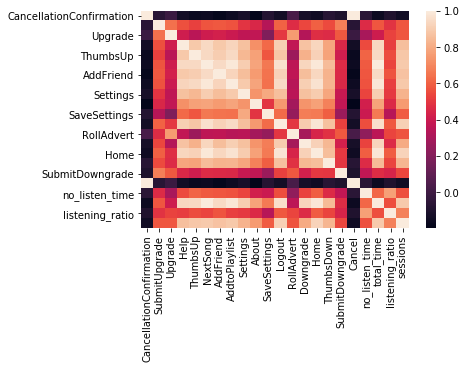

In [37]:
sns.heatmap(feature_engineered.toPandas().corr())

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [14]:
from pyspark.ml.feature import VectorAssembler


ignore = ['userId',"CancellationConfirmation", 'Cancel' ]

#removing Cancel column, as they have to click cancel to get to cancellation, an unavoidable step in cancelling
#if they are are hitting the cancel page, it is nearly 100% that they will follow through with cancellation.


assembler_page = VectorAssembler(
  inputCols=[x for x in feature_engineered.columns if x not in ignore], outputCol="features"
)

assembled = assembler_page.transform(feature_engineered)

In [15]:

final = assembled.select(['userId','features',"CancellationConfirmation"])

In [16]:
#assembled.toPandas().describe()
#the ratio of cancellations to non cancellations is 0.23111 which will be the initial weights for the churn class

In [17]:

splits = final.randomSplit([0.7, 0.3], seed=42) #42 seed for test
train_df = splits[0]
test_val = splits[1]

In [18]:
#checking the ratio of the different classes to make sure they are the same

print (train_df.toPandas()['CancellationConfirmation'].value_counts())

print (test_val.toPandas()['CancellationConfirmation'].value_counts())

0    118
1     34
Name: CancellationConfirmation, dtype: int64
0    55
1    18
Name: CancellationConfirmation, dtype: int64


In [19]:
#scaling the vectors so that they can be used with the logisitic regression classifier
#seperating the train and test so there are no data leak after its scaled

from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

scalerModel = scaler.fit(train_df)

# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(train_df)


In [20]:
#downsampling, as an option for the larger dataset

train_df_sampled = scaledData.sampleBy("CancellationConfirmation", fractions= {0: 1.0, 1: 1.0 })
train_df_sampled.createOrReplaceTempView("train")

In [21]:
#adding weights
spark.udf.register("weight", lambda x: (x+1)*0.23 if x == 0 else 1)

train_df_model = spark.sql('''
            select *, cast(weight(CancellationConfirmation) as float) as weight
            from train
''')


# Modeling


In [22]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml import Pipeline

lr = LogisticRegression( featuresCol="scaledFeatures", labelCol="CancellationConfirmation", weightCol="weight")
dt = DecisionTreeClassifier(labelCol="CancellationConfirmation", featuresCol="scaledFeatures")

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="CancellationConfirmation", metricName= "f1")

pipeline = Pipeline(stages=[]) 

lr_stages = [lr]
dt_stages = [dt]

lr_pipeline = Pipeline(stages=lr_stages)
dt_pipeline = Pipeline(stages=dt_stages)

paramGrid_lr = ParamGridBuilder() \
    .baseOn({pipeline.stages:lr_stages})  \
    .addGrid(lr.maxIter, [200, ]) \
    .addGrid(lr.elasticNetParam, [0]) \
    .addGrid(lr.threshold, [0.6]) \
    .build()



paramGrid_dt = ParamGridBuilder() \
    .baseOn({pipeline.stages:dt_stages})\
    .addGrid(dt.maxDepth, [ 10, 15]) \
    .addGrid(dt.maxBins, [4,5,6]) \
    .build()

paramGrid = paramGrid_lr #+ paramGrid_dt

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2) 

cvModel = crossval.fit(train_df_model)


In [23]:
scaledtest = scalerModel.transform(test_val)

prediction = cvModel.transform(scaledtest)

In [24]:
cvModel.bestModel

PipelineModel_1a7e4a0f4c38

In [25]:
'''trainingsummary = cvModel.bestModel.summary
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(trainingsummary.pr.select('recall').collect(),
         trainingsummary.pr.select('precision').collect())
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()'''

"trainingsummary = cvModel.bestModel.summary\nimport matplotlib.pyplot as plt\nplt.figure(figsize=(5,5))\nplt.plot([0, 1], [0, 1], 'r--')\nplt.plot(trainingsummary.pr.select('recall').collect(),\n         trainingsummary.pr.select('precision').collect())\nplt.xlabel('recall')\nplt.ylabel('precision')\nplt.show()"

In [26]:
bestPipeline = cvModel.bestModel.stages[-1]

bestParams = bestPipeline.extractParamMap()
bestParams

{Param(parent='LogisticRegression_df009274b5b6', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_df009274b5b6', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LogisticRegression_df009274b5b6', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_df009274b5b6', name='featuresCol', doc='features column name'): 'scaledFeatures',
 Param(parent='LogisticRegression_df009274b5b6', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_df009274b5b6', name='labelCol', doc='label column name'): 'CancellationConfirmation',
 Param(parent='LogisticRegression_df009274b5b6', name='maxIter', doc='maximum number

In [27]:
print ("The precision for validation set is {}".format(evaluator.evaluate(prediction, {evaluator.metricName: "weightedPrecision"})))
print ("The recall for validation set is {}".format(evaluator.evaluate(prediction, {evaluator.metricName: "weightedRecall"})))
print ("The f1 for validation set is {}".format(evaluator.evaluate(prediction, {evaluator.metricName: "f1"})))

The precision for validation set is 0.7014643363249882
The recall for validation set is 0.6301369863013698
The f1 for validation set is 0.6528708831244536



- Pipeline: With the Decision Tree:

The precision for validation set is 0.6536680911680912

The recall for validation set is 0.6025641025641025

The f1 for validation set is 0.624395682083911

- With the Logistic Regression

The precision for validation set is 0.743443033745406

The recall for validation set is 0.5753424657534246

The f1 for validation set is 0.6019818045469951

False positives: 27 
False negatives: 4 
True Negatives: 28 
True positives: 14 


- Tested Logistic Regression threshold change to 0.7

The precision for validation set is 0.7069615517439853
The recall for validation set is 0.7123287671232876
The f1 for validation set is 0.7095149944465013
False positives: 10 
False negatives: 11 
True Negatives: 45 
True positives: 7 

- Threshold to 0.8
The precision for validation set is 0.7212437486410088
The recall for validation set is 0.7534246575342465
The f1 for validation set is 0.7265580947958473

The F1 score increased but it focusing to much on the recall at 0.8 threshold, the userids which are showing up as possible churners have much newer ids. I dont particularly want to make newer users, and the super high probability users the only ones who are at risk. My concern is that low usage stats are being identified as high churn, which doesn't really discern between new and old users. I think adding in the registration date as a feature would help correct some of this. 
False positives: 5 
False negatives: 13 
True Negatives: 50 
True positives: 5 

- Threshold to 0.6

The precision for validation set is 0.7014643363249882
The recall for validation set is 0.6301369863013698
The f1 for validation set is 0.6528708831244536

Testing a lower threshold. I think this threshold may be the best, when the full dataset is looked at, it maybe easier to see where to put the threshold since we will have more examples of churn. Further more, we can examine them more by probability further. I believe that this will give a small enough group to work with. 
False positives: 19 
False negatives: 8 
True Negatives: 36 
True positives: 10 

In [28]:
yaya = prediction.toPandas()

print (len(yaya))
print ("False positives: {} ".format(len(yaya[(yaya['prediction'] == 1) & (yaya['CancellationConfirmation'] == 0)])))
print ("False negatives: {} ".format(len(yaya[(yaya['prediction'] == 0) & (yaya['CancellationConfirmation'] == 1)])))
print ("True Negatives: {} ".format(len(yaya[(yaya['prediction'] == 0) & (yaya['CancellationConfirmation'] == 0)])))
print ("True positives: {} ".format(len(yaya[(yaya['prediction'] == 1) & (yaya['CancellationConfirmation'] == 1)])))

yaya[(yaya['prediction'] == 1) & (yaya['CancellationConfirmation'] == 0)]

73
False positives: 19 
False negatives: 8 
True Negatives: 36 
True positives: 10 


,userId,features,CancellationConfirmation,scaledFeatures,rawPrediction,probability,prediction
0,100010,"[0.0, 2.0, 2.0, 17.0, 275.0, 4.0, 7.0, 0.0, 1....",0,"[0.0, 0.812821832988, 0.267284637662, 0.247282...","[-1.21331093848, 1.21331093848]","[0.229115742889, 0.770884257111]",1.0
2,102,"(0.0, 0.0, 0.0, 6.0, 158.0, 0.0, 1.0, 1.0, 0.0...",0,"(0.0, 0.0, 0.0, 0.0872763454234, 0.13699157192...","[-1.47304005215, 1.47304005215]","[0.186480980716, 0.813519019284]",1.0
4,300014,"[1.0, 1.0, 4.0, 27.0, 280.0, 3.0, 10.0, 2.0, 1...",0,"[1.398520126, 0.406410916494, 0.534569275324, ...","[-1.10764255108, 1.10764255108]","[0.248310651094, 0.751689348906]",1.0
7,14,"[0.0, 0.0, 10.0, 54.0, 1230.0, 19.0, 34.0, 6.0...",0,"[0.0, 0.0, 1.33642318831, 0.78548710881, 1.066...","[-0.445871248472, 0.445871248472]","[0.390342860948, 0.609657139052]",1.0
8,200004,"[0.0, 0.0, 9.0, 85.0, 1742.0, 21.0, 67.0, 18.0...",0,"[0.0, 0.0, 1.20278086948, 1.2364148935, 1.5103...","[-6.96441187177, 6.96441187177]","[0.000944026477394, 0.999055973523]",1.0
12,89,"[1.0, 2.0, 5.0, 30.0, 667.0, 14.0, 12.0, 10.0,...",0,"[1.398520126, 0.812821832988, 0.668211594155, ...","[-0.469074766393, 0.469074766393]","[0.384835257361, 0.615164742639]",1.0
17,66,"[1.0, 3.0, 3.0, 52.0, 1045.0, 24.0, 38.0, 5.0,...",0,"[1.398520126, 1.21923274948, 0.400926956493, 0...","[-0.683947926694, 0.683947926694]","[0.335380736629, 0.664619263371]",1.0
23,200006,"[0.0, 2.0, 1.0, 21.0, 542.0, 8.0, 17.0, 2.0, 1...",0,"[0.0, 0.812821832988, 0.133642318831, 0.305467...","[-0.632388879756, 0.632388879756]","[0.346969064081, 0.653030935919]",1.0
28,63,"[0.0, 1.0, 0.0, 6.0, 87.0, 0.0, 1.0, 1.0, 0.0,...",0,"[0.0, 0.406410916494, 0.0, 0.0872763454234, 0....","[-0.63486352761, 0.63486352761]","[0.346408567122, 0.653591432878]",1.0
29,83,"[1.0, 4.0, 10.0, 69.0, 1235.0, 18.0, 28.0, 11....",0,"[1.398520126, 1.62564366598, 1.33642318831, 1....","[-2.69648127975, 2.69648127975]","[0.0631813072572, 0.936818692743]",1.0


In [30]:
#to see the values for the decision tree
#print (bestPipeline.toDebugString)